금리 보간

In [2]:
pip install pandas numpy openpyxl


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np


In [10]:
# ===============================================================
# 1) Excel 데이터 읽기 + 전처리
# ===============================================================

# 금리 파일 읽기
df = pd.read_excel("제로금리.xlsx")

# 날짜를 datetime으로 변환
df["Date"] = pd.to_datetime(df["Date"])

# 금리 컬럼명(모든 금리 열)
rate_cols = df.columns[1:]

# 금리를 float으로 강제 변환 (문자 → NaN 자동 처리)
for col in rate_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 금리가 % 단위일 경우 → 100으로 나눠서 0.01 형태로 바꿔줌
df[rate_cols] = df[rate_cols] / 100.0

# ELS 발행일
issue_date = pd.to_datetime("2021-10-22")


In [11]:
print(df.head)

<bound method NDFrame.head of           Date   Zero_3M   Zero_6M  Zero_1Y   Zero_2Y   Zero_3Y
0   2021-10-21  0.008045  0.009621  0.01144  0.016035  0.018410
1   2021-10-22  0.008338  0.009861  0.01170  0.016426  0.018942
2   2021-10-25  0.008477  0.009995  0.01184  0.016506  0.019244
3   2021-10-26  0.008693  0.010272  0.01216  0.016685  0.019525
4   2021-10-27  0.008938  0.010894  0.01299  0.017676  0.020496
..         ...       ...       ...      ...       ...       ...
740 2024-10-25  0.029653  0.029580  0.02851  0.028963  0.028818
741 2024-10-28  0.029768  0.029719  0.02873  0.029387  0.029323
742 2024-10-29  0.029738  0.029594  0.02867  0.029490  0.029363
743 2024-10-30  0.030138  0.029723  0.02870  0.029570  0.029371
744 2024-10-31  0.029745  0.029773  0.02875  0.029651  0.029358

[745 rows x 6 columns]>


In [13]:
# ===============================================================
# 2) 금리 → DF, DF → 금리 변환 함수
# ===============================================================

def rate_to_df(rate, T):
    """
    continuous compounding 기준:
    DF = exp( - r * T )
    """
    return np.exp(-rate * T)

def df_to_rate(df, T):
    """
    DF → zero rate 변환:
    r = - log(DF) / T
    """
    return -np.log(df) / T



# ===============================================================
# 3) Log-DF 보간 함수 (실무 표준)
# ===============================================================
def interp_log_df(target_T, curve_T,  curve_df):
    """

    1) DF 값에 로그를 취함   -> log(DF)
    2) 시간구간 T에 대해 선형 보간
    3) 보간된 log DF 값을 exp()로 다시 DF로 복원

    이렇게 하면 '할인계수는 시간에 대해 log-linear' 라는
    실무 가정이 그대로 반영됨.

    """
    """
    T_curve: 원본 만기들
    DF_curve: 해당 DF들
    T_target: 보간할 만기
    """

    # numpy float array로 강제 변환 (object 타입 문제 방지)
    curve_T = np.array(curve_T, dtype=float)
    curve_df = np.array(curve_df, dtype=float)
    target_T = float(target_T)

    # log DF 값 계산
    logdf = np.log(curve_df)

    # log DF를 대상으로 선형 보간
    interp_logdf = np.interp(target_T, curve_T, logdf)

    # 다시 DF로 복원
    return np.exp(interp_logdf)






# ============================================
# 5) 잔존만기 기준 금리곡선 생성
# ============================================
def build_daily_curve(df, issue_date, tenors):
    results = []

    base_T = np.array([0.25, 0.5, 1.0, 2.0, 3.0])  # 3M, 6M, 1Y, 2Y, 3Y

    for _, row in df.iterrows():
        today = row["Date"]
        days_passed = (today - issue_date).days

        if days_passed < 0:
            continue  # 발행 이전이면 skip

        # 매일 잔존만기 계산
        remain_T = np.array(tenors) - days_passed / 365
        valid = remain_T > 0
        remain_T = remain_T[valid]

        # curve 금리 읽기
        curve_r = row[rate_cols].values.astype(float)

        # 금리를 DF로 변환
        curve_df = rate_to_df(curve_r, base_T)

        # 각 잔존만기마다 보간하여 금리 계산
        for T in remain_T:
            DF_t = interp_log_df(T, base_T, curve_df)
            r_t = df_to_rate(DF_t, T)

            results.append({
                "date": today,
                "days_passed": days_passed,
                "remain_T": T,
                "zero_rate": r_t
            })

    return pd.DataFrame(results)

In [14]:
out = build_daily_curve(df, issue_date, tenors=[0.5,1,1.5,2,3])
print(out.head)

<bound method NDFrame.head of            date  days_passed  remain_T  zero_rate
0    2021-10-22            0  0.500000   0.009861
1    2021-10-22            0  1.000000   0.011700
2    2021-10-22            0  1.500000   0.014851
3    2021-10-22            0  2.000000   0.016426
4    2021-10-22            0  3.000000   0.018942
...         ...          ...       ...        ...
1968 2024-10-14         1088  0.019178   0.380552
1969 2024-10-15         1089  0.016438   0.444783
1970 2024-10-16         1090  0.013699   0.538065
1971 2024-10-17         1091  0.010959   0.670824
1972 2024-10-18         1092  0.008219   0.913200

[1973 rows x 4 columns]>


In [15]:
out.to_excel("zero_curve_daily2.xlsx", index=False)


금리 보간 잘 됐는지 체크

In [49]:
import sys
print(sys.executable)

import seaborn as sns
print("Seaborn OK:", sns.__version__)

/opt/homebrew/opt/python@3.11/bin/python3.11
Seaborn OK: 0.13.2


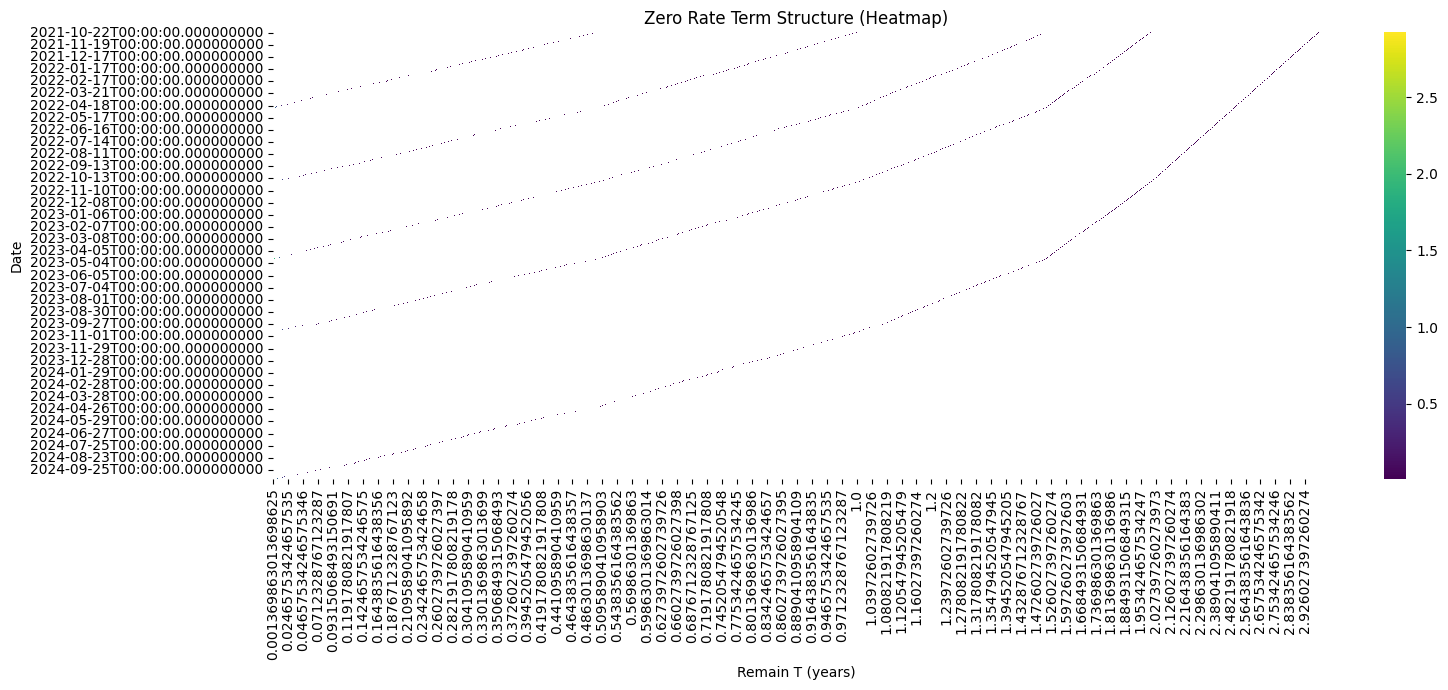

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 원본 입력 데이터
df_orig = pd.read_excel("금리_4.xlsx")
df_orig["일자"] = pd.to_datetime(df_orig["일자"])

# 보간된 결과 데이터
df_interp = pd.read_excel("일자별_잔존만기별_금리.xlsx")   # 파일명 맞춰 수정
df_interp["date"] = pd.to_datetime(df_interp["date"])

# 피벗 테이블 생성
pivot = df_interp.pivot(index="date", columns="remain_T", values="zero_rate")

# 히트맵 출력
plt.figure(figsize=(16, 7))
sns.heatmap(pivot, cmap="viridis", annot=False)
plt.title("Zero Rate Term Structure (Heatmap)")
plt.xlabel("Remain T (years)")
plt.ylabel("Date")
plt.tight_layout()
plt.show()



In [52]:
import numpy as np

# ============================================================
# 1. KOFR OIS Zero Curve (2025.10.16)
# ============================================================
ois_terms = np.array([
    1/52, 2/52, 1/12, 3/12, 6/12, 9/12,
    1.0, 1.5, 2.0, 3.0, 4.0, 5.0,
    6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0
])

ois_rates = np.array([
    2.49972, 2.47211, 2.45217, 2.41771, 2.39821, 2.37921,
    2.36571, 2.36371, 2.36871, 2.41741, 2.46321, 2.50171,
    2.53121, 2.56071, 2.58621, 2.60841, 2.63121, 2.66371,
    2.64621, 2.55721
]) / 100

def discount_OIS(t):
    if t <= ois_terms[0]:
        return np.exp(-ois_rates[0] * t)
    if t >= ois_terms[-1]:
        return np.exp(-ois_rates[-1] * t)

    i = np.searchsorted(ois_terms, t) - 1
    df_i = np.exp(-ois_rates[i] * ois_terms[i])
    df_j = np.exp(-ois_rates[i+1] * ois_terms[i+1])
    w = (t - ois_terms[i]) / (ois_terms[i+1] - ois_terms[i])
    lnDF = np.log(df_i) + w * (np.log(df_j) - np.log(df_i))
    return np.exp(lnDF)


# ============================================================
# 2. 선물에서 추정한 (r−q) 값
# ============================================================

# 삼성전자(근월물)
r_q_samsung = np.log(97800 / 97700) / 0.08     # T=0.08년
# 코스피200(근월물)
r_q_kospi   = np.log(524.6 / 524.45) / 0.17    # T=0.17년

# 두 자산을 벡터로 정리
r_minus_q = np.array([r_q_samsung, r_q_kospi])


# ============================================================
# 3. ELS Pricing Class
# ============================================================
class ELS2Star18215:
    def __init__(self,
                 T=3.0, gap=0.5,
                 step_down=(0.90, 0.85, 0.80, 0.80, 0.75),
                 redemp_pay=(1.0410, 1.0820, 1.1230, 1.1640, 1.2050),
                 maturity_pay=1.2460,
                 ki=0.52,
                 sigma=(0.2442, 0.3331),
                 rho=0.7477,
                 drift=None,            # << drift = (r−q) 넣는 곳
                 S0=(1.0, 1.0),
                 n_paths = 200000,
                 seed=42):

        self.T = T
        self.gap = gap
        self.obs = np.arange(gap, T+1e-12, gap)[:len(step_down)]
        self.step_down = np.array(step_down)
        self.redemp_pay = np.array(redemp_pay) * 10000
        self.maturity_pay = maturity_pay * 10000
        self.ki = ki

        self.sigma = np.array(sigma)
        self.rho = rho
        self.drift = np.array(drift)
        self.S0 = np.array(S0)

        self.n_paths = n_paths
        self.rng = np.random.default_rng(seed)

        corr = np.array([[1, rho], [rho, 1]])
        D = np.diag(self.sigma)
        cov = D @ corr @ D
        self.L = np.linalg.cholesky(cov)

    # -----------------------------
    # 시뮬레이션 (drift = r−q)
    # -----------------------------
    def _simulate(self, S0, T_remain, steps_per_year=252):

        dt = 1/steps_per_year
        n_steps = int(T_remain * steps_per_year)

        paths = np.zeros((self.n_paths, n_steps+1, 2))
        paths[:, 0] = S0

        drift = (self.drift - 0.5*self.sigma**2) * dt
        sdt = np.sqrt(dt)

        Z = self.rng.standard_normal((self.n_paths, n_steps, 2))
        dW = Z @ self.L.T

        for t in range(n_steps):
            incr = np.exp(drift + sdt * dW[:, t])
            paths[:, t+1] = paths[:, t] * incr

        return paths
    # -----------------------------
    # 가격 계산
    # -----------------------------
    def price(self, t0, S0_current, past_min, steps_per_year=252):
        """
        t0: 현재 시점 (년 단위)
        S0_current: (S1_t0, S2_t0)
        past_min: (min1, min2)  # t0까지의 최소값
        """

        # 남은 기간
        T_remain = self.T - t0
        if T_remain <= 0:
            raise ValueError("t0 must be earlier than maturity.")

        # 남은 관측일
        remain_obs = self.obs[self.obs > t0]
        obs_idx = ((remain_obs - t0) * steps_per_year).astype(int)

        # 중간 시점 기준으로 시뮬레이션
        paths = self._simulate(S0_current, T_remain, steps_per_year)
        n = len(paths)

        # 과거 최소와 이후 최소를 합쳐 낙인 여부 판정
        future_min = paths.min(axis=1).min(axis=1)
        ki_touch = np.minimum(future_min, np.min(past_min)) < self.ki

        payoff = np.zeros(n)
        redeemed = np.zeros(n, dtype=bool)

        # 남은 조기상환만 체크
        for i, idx in enumerate(obs_idx):
            cond = (~redeemed) & np.all(paths[:, idx] >= self.step_down[i + len(self.obs)-len(remain_obs)], axis=1)
            payoff[cond] = self.redemp_pay[i + len(self.obs)-len(remain_obs)] * discount_OIS(remain_obs[i])
            redeemed |= cond

        not_red = ~redeemed
        if np.any(not_red):
            worst_T = paths[not_red, -1].min(axis=1)
            ki_hit = ki_touch[not_red]

            p = np.zeros_like(worst_T)
            p[(worst_T >= 0.70)] = self.maturity_pay
            p[(worst_T < 0.70) & (~ki_hit)] = self.maturity_pay
            p[(worst_T < 0.70) & (ki_hit)] = 10000 * worst_T[(worst_T < 0.70) & (ki_hit)]

            payoff[not_red] = p * discount_OIS(T_remain)

        return payoff.mean(), payoff.std(ddof=1)/np.sqrt(n)
        
    def delta(self, t0, S0_current, past_min, h=0.01, 
            steps_per_year=252):
        """
        기초자산 변화에 대한 델타 계산 (중앙 차분)
        S0_current: (S1, S2)
        h: bump 크기 (예: 0.01 = 1%)
        """

        S1, S2 = S0_current

        # Seed 보존
        original_rng = self.rng
        self.rng = np.random.default_rng(12345)  # 공통 난수 사용

        # Δ1 계산
        V_up = self.price(t0, (S1*(1+h), S2), past_min, steps_per_year=steps_per_year)[0]
        V_dn = self.price(t0, (S1*(1-h), S2), past_min, steps_per_year=steps_per_year)[0]
        delta1 = (V_up - V_dn) / (2 * S1 * h)

        # Δ2 계산
        V_up2 = self.price(t0, (S1, S2*(1+h)), past_min, steps_per_year=steps_per_year)[0]
        V_dn2 = self.price(t0, (S1, S2*(1-h)), past_min, steps_per_year=steps_per_year)[0]
        delta2 = (V_up2 - V_dn2) / (2 * S2 * h)

        # rng 원상복구
        self.rng = original_rng

        return delta1, delta2

In [53]:
model = ELS2Star18215(
    drift=r_minus_q,
    sigma=(0.2442, 0.3331)
)

In [54]:
t0 = 1.0
S0_current = (0.92, 1.05)
past_min = (0.88, 0.95)

price = model.price(t0, S0_current, past_min)
delta1, delta2 = model.delta(t0, S0_current, past_min)

print(price)
print("Delta w.r.t S1 =", delta1)
print("Delta w.r.t S2 =", delta2)

(10286.603063203065, 4.450329434069253)
Delta w.r.t S1 = 2429.161218425456
Delta w.r.t S2 = 2391.2393258177913
